# Plot loss, training and dev accuracy

In [15]:
import pandas as pd
# log_fpath = '/projects/tumblr_community_identity/log/model2021-03-03_09-53.csv'
log = pd.read_csv(log_fpath, parse_dates=[[0, 1]], infer_datetime_format=True)
# log = pd.read_csv(log_fpath)
# print(log.date.dtype)
# print(log.time.dtype)
log

,date_time,epoch,iteration,loss,train_accuracy,dev_accuracy
0,2021-03-03 09:54:00,1,1,50.900818,0.000034,0.503741
1,2021-03-03 09:54:00,1,11,10.076620,0.000609,0.492292
2,2021-03-03 09:54:00,1,21,26.469135,0.001375,0.477148
3,2021-03-03 09:55:00,1,31,11.028381,0.002028,0.496710
4,2021-03-03 09:55:00,1,41,19.322281,0.002648,0.503741
...,...,...,...,...,...,...
4435,2021-03-04 05:43:00,6,7351,35.449657,0.600636,0.511494
4436,2021-03-04 05:44:00,6,7361,41.884151,0.601334,0.511404
4437,2021-03-04 05:44:00,6,7371,34.039974,0.602056,0.512395
4438,2021-03-04 05:44:00,6,7381,33.939621,0.602867,0.513387


In [16]:
log.date_time.dtype

dtype('<M8[ns]')

In [18]:
# Calculate time/epoch
log.rename(columns={'date_time': 'datetime'}, inplace=True)
duration = log.datetime.max() - log.datetime.min()
duration/log.epoch.max()

Timedelta('0 days 03:18:20')

In [23]:
# Get last metrics/epoch
score_cols = ['loss', 'train_accuracy', 'dev_accuracy']
gped = log.groupby('epoch').agg({col: lambda x: x.tolist()[-1] for col in score_cols})
gped

,loss,train_accuracy,dev_accuracy
epoch,,,
1,20.296127,0.538417,0.514739
2,36.413116,0.531487,0.606689
3,36.937347,0.553631,0.600469
4,33.680122,0.576237,0.597674
5,28.825102,0.575888,0.600919
6,11.971392,0.603599,0.506626


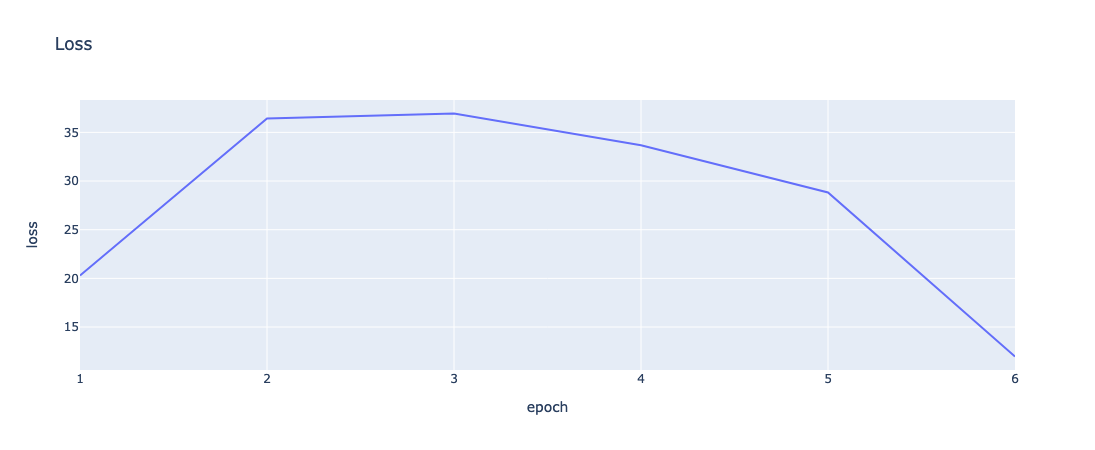

In [25]:
import plotly.express as px
fig = px.line(gped, x=gped.index, y='loss', title='Loss')
fig

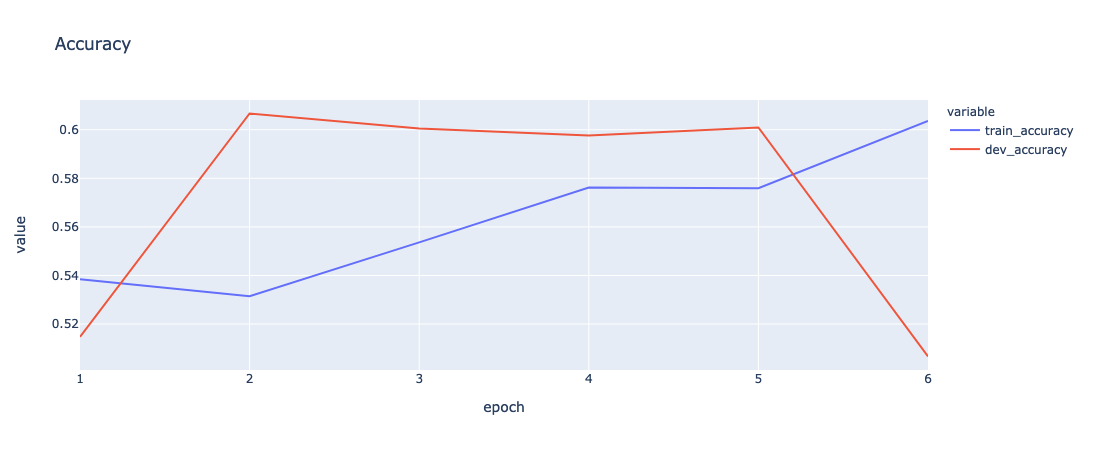

In [26]:
import plotly.express as px
fig = px.line(gped, x=gped.index, y=['train_accuracy', 'dev_accuracy'], title='Accuracy')
fig

# Simple CNN text classification
Inspired by https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f

## Load, format data
Should be fed in as a sentence of word token IDs

In [19]:
# Load pretrained word embeddings
from gensim.models import word2vec, KeyedVectors

fpath = '/projects/tumblr_community_identity/websci_exp_20210107/model/post+all_blog_sg_w2v.model'
word_embs = word2vec.Word2Vec.load(fpath)
word_embs.vector_size

64

In [59]:
# Load in data
import pandas as pd
data = pd.read_csv('/data/tumblr_community_identity/dataset114k/matched_reblogs_nonreblogs_dataset114k.csv')
# data.columns

# Build vocabulary, convert to word indices
from collections import defaultdict


selected = data.loc[:, ['processed_tumblr_blog_description_follower_reblog', 'processed_tumblr_blog_description_followee_reblog',
                    'processed_tumblr_blog_description_followee_nonreblog']]
selected['desc_follower'] = selected['processed_tumblr_blog_description_follower_reblog'].astype(str)
selected['desc_followee_reblog'] = selected['processed_tumblr_blog_description_followee_reblog'].astype(str)
selected['desc_followee_nonreblog'] = selected['processed_tumblr_blog_description_followee_nonreblog'].astype(str)
selected

# w2i = defaultdict(lambda: len(w2i))
# words = selected[['desc_follower', 'desc_followee_reblog', 'desc_followee_nonreblog']].agg(' '.join, axis=1)
# # words

# from collections import Counter
# words_ctr = Counter([w for s in words.tolist() for w in s.split()])
# words_ctr.most_common(20)

vocab = dict()
# for i, (w, count) in enumerate(words_ctr.most_common(100000)):
#     vocab[w] = i+1
# len(vocab)
for w, vec in word_embs.wv.vocab.items():
    vocab[w] = vec.index + 1 # add one for padding

for user in ['follower', 'followee_reblog', 'followee_nonreblog']:
    print(user)
    selected[f'indices_{user}'] = selected[f'desc_{user}'].map(lambda x: [vocab[w] for w in x.split() if w in vocab])
# selected[[col for col in selected.columns if 'indices' in col]]

# Pad to length
desc_length = 30

def pad(inds):
    while len(inds) < desc_length:
        inds.insert(len(inds), 0)
    return inds[:desc_length]

for user in ['follower', 'followee_reblog', 'followee_nonreblog']:
    selected[f'indices_{user}'] = selected[f'indices_{user}'].map(lambda x: pad(x))
selected[[col for col in selected.columns if 'indices' in col]]

/usr0/home/mamille2/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (12,29,38,42,51,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


follower
followee_reblog
followee_nonreblog


,indices_follower,indices_followee_reblog,indices_followee_nonreblog
0,"[3, 3906, 15, 8, 21014, 3933, 10, 31, 242, 264...","[28, 451, 6847, 162, 29, 15, 38, 8, 998, 356, ...","[3885, 85, 2301, 85, 12284, 1167, 85, 19320, 2..."
1,"[27, 8829, 2597, 3, 297, 451, 0, 0, 0, 0, 0, 0...","[3827, 23, 352, 30, 371, 371, 371, 371, 1395, ...","[1637, 3276, 5, 1283, 769, 59, 10, 7481, 1, 6,..."
2,"[439, 33, 21945, 180501, 8829, 810, 2, 71, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2348, 10, 69715, 876, 5, 1279, 0, 0, 0, 0, 0,..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 2970, 4, 32, 8, 11831, 1, 0, 0, 0, 0, 0, 0...","[432, 412, 2, 52, 6, 416, 2, 6, 14513, 3, 1953..."
4,"[6, 483, 261, 50, 8, 2244, 3294, 69, 802, 4, 1...","[51195, 21945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[7409, 1, 2262, 1, 5679, 1, 38, 7930, 45, 998,..."
...,...,...,...
110917,"[3594, 1124, 12917, 1124, 1762, 139, 23, 1103,...","[3122, 55, 126, 4, 254, 3122, 0, 0, 0, 0, 0, 0...","[1124, 1399, 1124, 6, 70, 192, 28, 189, 1493, ..."
110918,"[2, 7863, 8182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2085, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[371, 12909, 9, 371, 1154, 5693, 9555, 785, 0,..."
110919,"[1328, 11, 1854, 7, 90, 11, 213, 0, 0, 0, 0, 0...","[32, 182, 5, 27, 182, 18, 18, 0, 0, 0, 0, 0, 0...","[11567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
110920,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[79700, 79700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [60]:
# Feed random labels
import numpy as np

def add_random_labels(data):
    """ Add random 0 and 1 labels for ordering reblog/nonreblogs
        for learning-to-rank organization """
    half_len = int(len(data)/2)
    np.random.seed(9)
    labels = [0]*half_len + [1]*half_len
    np.random.shuffle(labels)
    data['label'] = labels
    return data

data = add_random_labels(selected)
# data

# Arrange into proper order
def rank_feature_transform(desc_followers, desc_followee_reblogs, desc_followee_nonreblogs, labels):
    """ Transform features to come up with comparison features for
        learning-to-rank formulation """
    comparison_feats = []
    for desc_follower, desc_followee_reblog, desc_followee_nonreblog, label in zip(
        desc_followers, desc_followee_reblogs, desc_followee_nonreblogs, labels):
        if label == 0:
            comparison_feats.append(desc_follower + desc_followee_reblog + desc_followee_nonreblog)
        else:
            comparison_feats.append(desc_follower + desc_followee_nonreblog + desc_followee_reblog)
    return np.array(comparison_feats)

ordered = rank_feature_transform(data['indices_follower'], data['indices_followee_reblog'], 
                                 data['indices_followee_nonreblog'], data['label'])
ordered.shape

(110922, 90)

In [ ]:
feature_opts = {} # reblog and nonreblog
130             for reblog_type in ['reblog', 'nonreblog']:
131                 feature_opts[reblog_type] = data[
132                     f'post_note_count_{reblog_type}'].fillna(0).values
133             feature_parts['post_note_count'] = rank_feature_transform(
134                 feature_opts['reblog'], feature_opts['nonreblog'], data.label)
135
136             # Post type
137             # Convert types to ints
138             feature_opts = {} # reblog and nonreblog
139             for reblog_type in ['reblog', 'nonreblog']:
140                 feature_opts[reblog_type] = pd.get_dummies(
141                     data[f'post_type_{reblog_type}']).values
142             feature_parts['post_type'] = rank_feature_transform(
143                 feature_opts['reblog'], feature_opts['nonreblog'], data.label)

In [61]:
# Split into train, dev, test
from sklearn.model_selection import train_test_split

size = 10000
X = ordered[:size]
y = data['label'].values[:size]
test_size = int(0.1 * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=test_size)
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 90)
(8000,)
(1000, 90)
(1000,)
(1000, 90)
(1000,)


## Build, train model

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TextClassifier(nn.ModuleList):
    def __init__(self, params):
        super(TextClassifier, self).__init__()
  
        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = params.embedding_size
        
        # Dropout definition
        self.dropout = nn.Dropout(0.25)
        
        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5
        
        # Output size for each convolution
        self.out_size = params.out_size
        # Number of strides for each convolution
        self.stride = params.stride
        
        # Embedding layer definition
#         self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)
        weights = torch.FloatTensor(word_embs.wv.vectors)
        zeros = torch.zeros(1, params.embedding_size)
        weights_with_padding = torch.cat((zeros, weights), 0)
        self.embedding = nn.Embedding.from_pretrained(weights_with_padding, padding_idx=0)
        
        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
        
        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
        
        # Fully connected layer definition
        self.fc = nn.Linear(self.in_features_fc(), 1)

    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calculate size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calculate size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calculate size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calculate size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
    
    def forward(self, x):

        # Sequence of tokes is filtered through an embedding layer
        x = self.embedding(x)
        
        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)
        
        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)
        
        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)
        
        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)
        
        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2) # add post notes and post type here
        union = union.reshape(union.size(0), -1)
    
        # The "flattened" vector is passed through a fully connected layer
        out = self.fc(union)
        # Dropout is applied		
        out = self.dropout(out)
        # Activation function is applied
        out = torch.sigmoid(out)
        
        return out.squeeze()

In [63]:
from dataclasses import dataclass

@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = 90
    num_words: int = 100000
    
    # Model parameters
#     embedding_size: int = 64
    embedding_size: int = word_embs.vector_size
    out_size: int = 32
    stride: int = 2
    
    # Training parameters
    epochs: int = 10
    batch_size: int = 12
    learning_rate: float = 0.001

In [64]:
model = TextClassifier(Parameters)

In [65]:
from torch.utils.data import Dataset, DataLoader

class DatasetMapper(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
      
    def __len__(self):
        return len(self.x)
       
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

import torch.optim as optim

# Initialize dataset mapper
params = Parameters()
train = DatasetMapper(X_train, y_train)
dev = DatasetMapper(X_dev, y_dev)

# Initialize loaders
loader_train = DataLoader(train, batch_size=params.batch_size)
loader_dev = DataLoader(dev, batch_size=params.batch_size)

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)

def evaluation(model, loader_test):
		
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Starst evaluation phase
    with torch.no_grad():
        for x_batch, y_batch in loader_test:
            y_pred = model(x_batch)
            predictions += list(y_pred.detach().numpy())
    return predictions

def calculate_accuracy(grand_truth, predictions):
    # Metrics calculation
    true_positives = 0
    true_negatives = 0
    for true, pred in zip(grand_truth, predictions):
        if (pred >= 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
        else:
            pass
    # Return accuracy
    return (true_positives+true_negatives) / len(grand_truth)

In [66]:
import torch

# Starts training phase
# for epoch in range(params.epochs):
for epoch in range(3):
    print(epoch)
    # Set model in training model
    model.train()
    predictions = []
    # Starts batch training
    for x_batch, y_batch in loader_train:

        y_batch = y_batch.type(torch.FloatTensor)

        # Feed the model
        y_pred = model(x_batch)

        # Loss calculation
        loss = F.binary_cross_entropy(y_pred, y_batch)

        # Clean gradientes
        optimizer.zero_grad()

        # Gradients calculation
        loss.backward()

        # Gradients update
        optimizer.step()

        # Save predictions
        predictions += list(y_pred.detach().numpy())
        
        # Evaluation phase
        dev_predictions = evaluation(model, loader_dev)

        # Metrics calculation
        train_accurary = calculate_accuracy(y_train, predictions)
        dev_accuracy = calculate_accuracy(y_dev, dev_predictions)
        print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Dev accuracy: %.5f" % (epoch+1, loss.item(), train_accurary, dev_accuracy))

0
Epoch: 1, loss: 0.68919, Train accuracy: 0.00100, Dev accuracy: 0.51500
Epoch: 1, loss: 1.91755, Train accuracy: 0.00162, Dev accuracy: 0.48400
Epoch: 1, loss: 0.75961, Train accuracy: 0.00213, Dev accuracy: 0.51500
Epoch: 1, loss: 1.19951, Train accuracy: 0.00250, Dev accuracy: 0.48500
Epoch: 1, loss: 0.82403, Train accuracy: 0.00313, Dev accuracy: 0.52100
Epoch: 1, loss: 0.68819, Train accuracy: 0.00387, Dev accuracy: 0.48500
Epoch: 1, loss: 0.81431, Train accuracy: 0.00450, Dev accuracy: 0.48500
Epoch: 1, loss: 0.70549, Train accuracy: 0.00537, Dev accuracy: 0.48600
Epoch: 1, loss: 0.76747, Train accuracy: 0.00575, Dev accuracy: 0.51500
Epoch: 1, loss: 0.75100, Train accuracy: 0.00637, Dev accuracy: 0.48400
Epoch: 1, loss: 0.66358, Train accuracy: 0.00713, Dev accuracy: 0.48200
Epoch: 1, loss: 0.68934, Train accuracy: 0.00800, Dev accuracy: 0.47700
Epoch: 1, loss: 0.71786, Train accuracy: 0.00863, Dev accuracy: 0.50800
Epoch: 1, loss: 0.70669, Train accuracy: 0.00937, Dev accuracy